# Rag From Scratch: Query Construction

In [1]:
! pip install --upgrade --quiet langchain_community tiktoken langchain-groq langchain-huggingface langchainhub chromadb langchain youtube-transcript-api pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.3 MB/s eta 0:00:00

In [2]:
import os
from google.colab import userdata
from uuid import uuid4

unique_id = uuid4()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["USER_AGENT"] = "myagent"

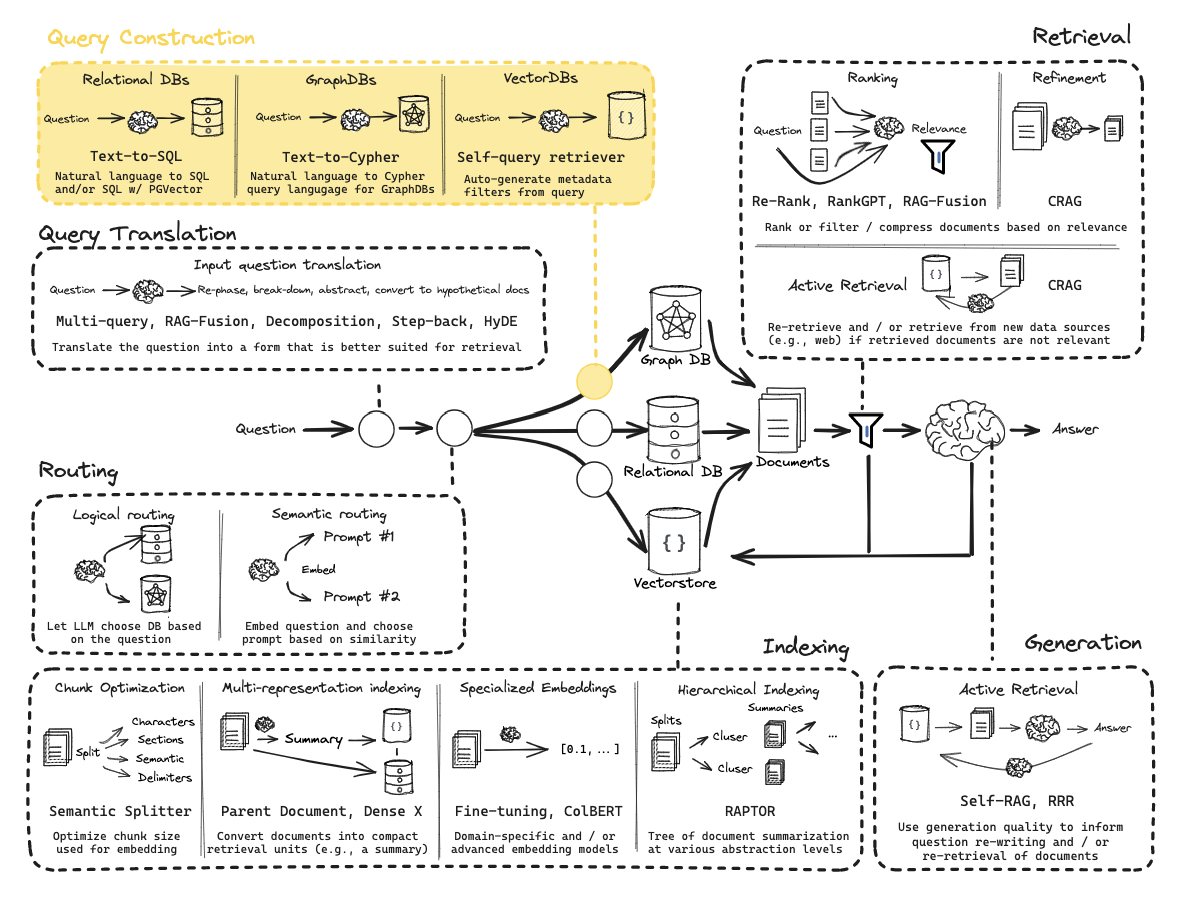

For graph and SQL, see helpful resources:

https://blog.langchain.dev/query-construction/

https://blog.langchain.dev/enhancing-rag-based-applications-accuracy-by-constructing-and-leveraging-knowledge-graphs/

## Part 11: Query structuring for metadata filters

### VectorDBs: Self-query retriever

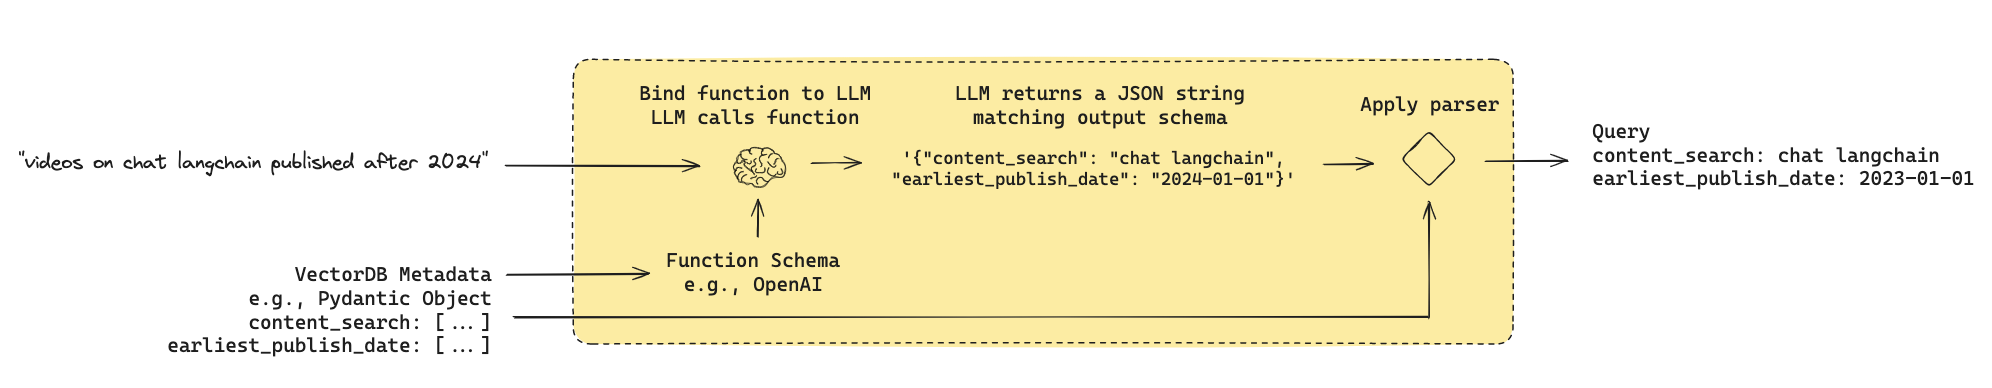

Many vectorstores contain metadata fields.

This makes it possible to filter for specific chunks based on metadata.

Let's look at some example metadata we might see in a database of YouTube transcripts.

In [3]:
from langchain_community.document_loaders import YoutubeLoader

docs = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=pbAd8O1Lvm4", add_video_info=True
).load()

docs[0].metadata

{'source': 'pbAd8O1Lvm4',
 'title': 'Self-reflective RAG with LangGraph: Self-RAG and CRAG',
 'description': 'Unknown',
 'view_count': 23511,
 'thumbnail_url': 'https://i.ytimg.com/vi/pbAd8O1Lvm4/hq720.jpg',
 'publish_date': '2024-02-07 00:00:00',
 'length': 1058,
 'author': 'LangChain'}

Let’s assume we’ve built an index that:

1. Allows us to perform unstructured search over the `contents` and `title` of each document
2. And to use range filtering on `view count`, `publication date`, and `length`.

We want to convert natural langugae into structured search queries.

We can define a schema for structured search queries.

In [4]:
import datetime
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


Now, we prompt the LLM to produce queries.

In [15]:
from langchain.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

In [16]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

content_search: convert rag to database query
title_search: rag conversion


In [19]:
query_analyzer.invoke(
    {"question": "videos on chat langchain published in 2023"}
).pretty_print()

content_search: video
title_search: langchain
earliest_publish_date: 2023-01-01
latest_publish_date: 2024-01-01


In [20]:
query_analyzer.invoke(
    {"question": "videos that are focused on the topic of chat langchain that are published before 2024"}
).pretty_print()

content_search: chat langchain
title_search: chat langchain
earliest_publish_date: 2022-01-01


In [21]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

content_search: multi-modal models
title_search: multi-modal models
max_length_sec: 300


To then connect this to various vectorstores, you can follow here: https://python.langchain.com/docs/how_to/self_query/.

For Relational DBs and GraphDBs: https://medium.com/@samarrana407/mastering-rag-advanced-methods-to-enhance-retrieval-augmented-generation-4b611f6ca99a